# File Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import netCDF4
# import cartopy
import math
import sys
import os
import itertools

In [2]:
# !pip install cartopy

### Create supporting Functions

In [3]:
def find_closest_site(lat,long,df_sites):
    '''
    
    '''
    df_sites['lat-loc'] = np.abs(df_sites.lat-lat)
    df_sites['long-loc'] = np.abs(df_sites.long-long)
    df_sites['distance'] = [np.sqrt(x**2+y**2) for x,y in zip(df_sites['lat-loc'],df_sites['long-loc'])]
    closest_site = df_sites[df_sites.distance==np.min(df_sites['distance'])]
#     closest_site_id = closest_site.reset_index().loc[0,'site']
    
    closest_site = closest_site.rename(columns={'lat':'closest_lat','long':'closest_long'})
    
    return(closest_site)

In [4]:
list_of_locations = \
    {"Buckleton's Beach":{'lat':-36.392355, 'long':174.748399}
    }


# NZ SLR points for Richard

In [5]:
# List all AISs used
AISs = [
    "k14",
#     "dp16",
    "dp21",
    "k14v",
#     "dp16v",
    "dp21v"    
]

AIS_scenarios = {}

# Loop over each AIS type
for AIS in AISs:
    # Create list of rcp scenarios to loop over
    rcps = [
        "26",
        "85"
    ]

    # have one colour per rcp
    colours = [
        'k',
        'r'
    ]

    # Create an empty dictionary to store the quantile dataframes in
    rcp_scenarios = {}

    # loop over each rcp
    for rcp,colour in zip(rcps,colours):

        # get file name 
        file = "nz_coast/workflows/wf_{}/rcp{}/total-workflow_localsl.nc".format(AIS,rcp,rcp)
        
        # Load the data
        ds = netCDF4.Dataset(file)
            
        # Extract the variables
        time = np.array(ds.variables['years'])
        lat = np.array(ds.variables['lat'])
        long = np.array(ds.variables['lon'])
        localSL_quantiles = np.array(ds.variables['localSL_quantiles'])
        quantiles = np.array(ds.variables['quantiles'])
        site_id = np.array(ds.variables['id'])
        
        # Create a dataframe of the site locations
        site_locations = pd.DataFrame({'lat':lat,'long':long,'site':site_id})

        # get some quantiles for plotting (indexing them from the ds quantile list)
        quantile_value = 0.5
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        median_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        median_quantile.index = median_quantile.index.set_names(['site'])
        median_quantile = pd.melt(median_quantile.reset_index(),id_vars='site')
        median_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Lower IPCC likelihood quantile
        quantile_value = 0.17
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        lower_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        lower_quantile.index = lower_quantile.index.set_names(['site'])
        lower_quantile = pd.melt(lower_quantile.reset_index(),id_vars='site')
        lower_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Upper IPCC likelihood quantile
        quantile_value = 0.83
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        upper_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        upper_quantile.index = upper_quantile.index.set_names(['site'])
        upper_quantile = pd.melt(upper_quantile.reset_index(),id_vars='site')
        upper_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Get a dataframe of all the different locations
        df_locations = pd.DataFrame(list_of_locations).T
        df_sites = pd.concat([find_closest_site(row.lat,row.long,site_locations) for index,row in df_locations.iterrows()])
        df_locations.index = df_locations.index.set_names(['location'])
        df_sites.index = df_sites.index.set_names(['site_ids'])
        df_locations.reset_index(inplace=True)
        df_sites.reset_index(inplace=True,drop=True)
        df_locations = df_locations.join(df_sites)
        
        quantiles_across_sites = {}
            
        for index,row in df_locations.iterrows():
            median_quantile_site = median_quantile[median_quantile.site==row.site]
            lower_quantile_site = lower_quantile[lower_quantile.site==row.site]
            upper_quantile_site = upper_quantile[upper_quantile.site==row.site]

            quantiles_across_sites.update({
                row.site:{
                    'median':median_quantile_site,
                    'lower':lower_quantile_site,
                    'upper':upper_quantile_site,
                    'location':row.location,
                    'closest_lat':row.closest_lat,
                    'closest_long':row.closest_long,
                    'colour':colour
                }
            })
            
        rcp_scenarios.update({
            rcp:{
                "quantiles_dict":quantiles_across_sites,
            }
        })
        
    AIS_scenarios.update({
        AIS:rcp_scenarios
    })


In [6]:
# # Set up the figure
# fig = plt.figure(figsize=(15,10))
# plt.subplots_adjust(hspace=0,wspace=0.05)

# ax1 = plt.subplot2grid((2,2),(0,0))
# ax2 = plt.subplot2grid((2,2),(1,0))
# ax3 = plt.subplot2grid((2,2),(0,1))
# ax4 = plt.subplot2grid((2,2),(1,1))

# site = 2494

# def plot_slr_scenarios(scenario_name,ax):
#     '''
#     '''
#     for rcp,site_dict in AIS_scenarios[scenario_name].items():
        
#         quantile_dict = site_dict['quantiles_dict'][site]
        
#         ax.plot(quantile_dict['median'].year,quantile_dict['median'].SLR/1000,
#                 c=quantile_dict['colour'])
#         ax.fill_between(x=list(quantile_dict['lower'].year),
#                          y1=list(quantile_dict['lower'].SLR/1000),
#                          y2=list(quantile_dict['upper'].SLR/1000),
#                          zorder=-1000,
#                          color=quantile_dict['colour'],
#                          alpha=0.1)
#     return(ax)

# # plot the results
# ax1 = plot_slr_scenarios('k14',ax1)
# ax2 = plot_slr_scenarios('dp21',ax2)
# ax3 = plot_slr_scenarios('k14v',ax3)
# ax4 = plot_slr_scenarios('dp21v',ax4)
  
# y_min = np.min([np.min(ax.get_ylim()) for ax in [ax1,ax2,ax3,ax4]])
# y_max = np.max([np.max(ax.get_ylim()) for ax in [ax1,ax2,ax3,ax4]])    
    
# # Format the graph
# for ax,label in zip([ax1,ax2,ax3,ax4],['(a) K14','(b) DP21','(c) K14','(d) DP21']):
#     ax.set_ylabel('Mean sea-level change (m)')
#     ax.set_ylim([y_min,y_max])
#     ax.text(x=np.max(ax.get_xlim())-0.25*np.diff(ax.get_xlim())[0],
#             y=np.max(ax.get_ylim())-0.1*np.diff(ax.get_ylim())[0],
#             s=label,fontsize=15)
    
# for ax in [ax3,ax4]:
#     ax.yaxis.set_label_position('right')
    
# for ax in [ax2,ax4]:
#     ax.set_xlabel('Time (years)')

# for ax in [ax3,ax4]:
#     ax.yaxis.tick_right()
    
# for ax in [ax1,ax3]:
#     ax.set_xticklabels([])
    
# # for ax in [ax3,ax4]:
# #     ax.set_yticklabels([])
    
# ax1.set_title('No vertical land motion')
# ax3.set_title('Including vertical land motion')

# # for ax in [ax1,ax3]:
# #     ax.text(x=2020,y=np.max(ax1.get_ylim())-0.2*np.mean(ax1.get_ylim()),s='k14',fontsize=15)

# # for ax in [ax2,ax4]:
# #     ax.text(x=2020,y=np.max(ax3.get_ylim())-0.2*np.mean(ax3.get_ylim()),s='dp21',fontsize=15)

# l1 = plt.scatter([],[],c='k')
# l2 = plt.scatter([],[],c='r')

# ax4.legend([l1,l2],['RCP 2.6','RCP 8.5'],loc='upper left')

# fig.suptitle(AIS_scenarios['dp21']['26']['quantiles_dict'][site]['location'],fontsize=20)

# plt.show()

In [7]:
# # Set up the figure
# fig = plt.figure(figsize=(8,7))
# plt.subplots_adjust(hspace=0,wspace=0.05)

# ax1 = plt.subplot2grid((1,1),(0,0))

# site = 2494

# def plot_slr_scenarios(scenario_name,ax,col,output_list):
#     '''
#     '''
#     for rcp,site_dict in AIS_scenarios[scenario_name].items():
        
#         quantile_dict = site_dict['quantiles_dict'][site]
        
#         if rcp=='26':
#             pass
#         else:
#             continue
        
#         output, = ax.plot(quantile_dict['median'].year,quantile_dict['median'].SLR/1000,
#                 c=col)
#         ax.fill_between(x=list(quantile_dict['lower'].year),
#                          y1=list(quantile_dict['lower'].SLR/1000),
#                          y2=list(quantile_dict['upper'].SLR/1000),
#                          zorder=-1000,
#                          color=col,
#                          alpha=0.1)
#         output_list.append(output)
        
#     return(ax,output_list)

# output_list = []

# # plot the results
# ax1,output_list = plot_slr_scenarios('k14',ax1,'k',output_list)
# ax1,output_list = plot_slr_scenarios('dp21',ax1,'b',output_list)
# ax1,output_list = plot_slr_scenarios('k14v',ax1,'r',output_list)
# ax1,output_list = plot_slr_scenarios('dp21v',ax1,'g',output_list)

    
# # Format the graph
# for ax,label in zip([ax1,ax2],['(a) K14']):
#     ax.set_ylabel('Mean sea-level change (m)')
    
# for ax in [ax1]:
#     ax.set_xlabel('Time (years)')
#     ax.set_xlim([2005,np.max(ax.get_xlim())])

# l1 = plt.scatter([],[],c='k')
# l2 = plt.scatter([],[],c='b')
# l3 = plt.scatter([],[],c='r')
# l4 = plt.scatter([],[],c='g')

# ax1.legend([l1,l2,l3,l4],['K14','DP21','K14-VLM','DP21-VLM'],loc='upper left')

# ax1.set_title(AIS_scenarios['dp21']['26']['quantiles_dict'][site]['location']+': RCP 2.6',fontsize=20)

# plt.savefig('figures/{}_{}.png'.format(AIS_scenarios['dp21']['26']['quantiles_dict'][site]['location'],'rcp26'),dpi=300)

In [8]:
df_locations

,location,lat,long,closest_lat,closest_long,site,lat-loc,long-loc,distance
0,Buckleton's Beach,-36.392355,174.748399,-36.396557,174.744843,835,0.0042,0.003555,0.005503


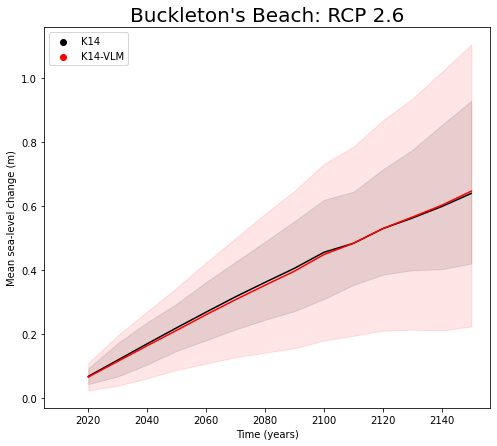

In [9]:

for site in df_locations.site:
    # Set up the figure
    fig = plt.figure(figsize=(8,7))
    plt.subplots_adjust(hspace=0,wspace=0.05)

    ax1 = plt.subplot2grid((1,1),(0,0))

    def plot_slr_scenarios(scenario_name,ax,col,output_list):
        '''
        '''
        for rcp,site_dict in AIS_scenarios[scenario_name].items():

            quantile_dict = site_dict['quantiles_dict'][site]

            if rcp=='26':
                pass
            else:
                continue

            output, = ax.plot(quantile_dict['median'].year,quantile_dict['median'].SLR/1000,
                    c=col)
            ax.fill_between(x=list(quantile_dict['lower'].year),
                             y1=list(quantile_dict['lower'].SLR/1000),
                             y2=list(quantile_dict['upper'].SLR/1000),
                             zorder=-1000,
                             color=col,
                             alpha=0.1)
            output_list.append(output)

        return(ax,output_list)

    output_list = []

    # plot the results
    ax1,output_list = plot_slr_scenarios('k14',ax1,'k',output_list)
#     ax1,output_list = plot_slr_scenarios('dp21',ax1,'b',output_list)
    ax1,output_list = plot_slr_scenarios('k14v',ax1,'r',output_list)
#     ax1,output_list = plot_slr_scenarios('dp21v',ax1,'g',output_list)


    # Format the graph
    for ax,label in zip([ax1],['(a) K14']):
        ax.set_ylabel('Mean sea-level change (m)')

    for ax in [ax1]:
        ax.set_xlabel('Time (years)')
        ax.set_xlim([2005,np.max(ax.get_xlim())])

    l1 = plt.scatter([],[],c='k')
#     l2 = plt.scatter([],[],c='b')
    l3 = plt.scatter([],[],c='r')
#     l4 = plt.scatter([],[],c='g')

    ax1.legend([l1,l3],['K14','K14-VLM'],loc='upper left')

    ax1.set_title(AIS_scenarios['dp21']['26']['quantiles_dict'][site]['location']+': RCP 2.6',fontsize=20)

    plt.savefig('figures/{}_{}.png'.format(AIS_scenarios['dp21']['26']['quantiles_dict'][site]['location'],'rcp26'),dpi=300)

# RCP 8.5

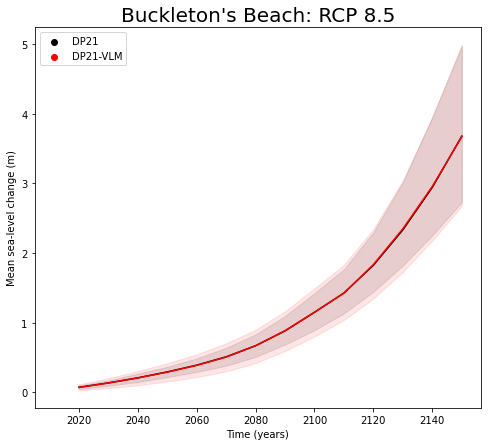

In [10]:

for site in df_locations.site:
    # Set up the figure
    fig = plt.figure(figsize=(8,7))
    plt.subplots_adjust(hspace=0,wspace=0.05)

    ax1 = plt.subplot2grid((1,1),(0,0))

    def plot_slr_scenarios(scenario_name,ax,col,output_list):
        '''
        '''
        for rcp,site_dict in AIS_scenarios[scenario_name].items():

            quantile_dict = site_dict['quantiles_dict'][site]

            if rcp=='85':
                pass
            else:
                continue

            output, = ax.plot(quantile_dict['median'].year,quantile_dict['median'].SLR/1000,
                    c=col)
            ax.fill_between(x=list(quantile_dict['lower'].year),
                             y1=list(quantile_dict['lower'].SLR/1000),
                             y2=list(quantile_dict['upper'].SLR/1000),
                             zorder=-1000,
                             color=col,
                             alpha=0.1)
            output_list.append(output)

        return(ax,output_list)

    output_list = []

    # plot the results
#     ax1,output_list = plot_slr_scenarios('k14',ax1,'k',output_list)
    ax1,output_list = plot_slr_scenarios('dp21',ax1,'k',output_list)
#     ax1,output_list = plot_slr_scenarios('k14v',ax1,'r',output_list)
    ax1,output_list = plot_slr_scenarios('dp21v',ax1,'r',output_list)


    # Format the graph
    for ax,label in zip([ax1],['(a) K14']):
        ax.set_ylabel('Mean sea-level change (m)')

    for ax in [ax1]:
        ax.set_xlabel('Time (years)')
        ax.set_xlim([2005,np.max(ax.get_xlim())])

    l1 = plt.scatter([],[],c='k')
#     l2 = plt.scatter([],[],c='b')
    l3 = plt.scatter([],[],c='r')
#     l4 = plt.scatter([],[],c='g')

    ax1.legend([l1,l3],['DP21','DP21-VLM'],loc='upper left')

    ax1.set_title(AIS_scenarios['dp21']['85']['quantiles_dict'][site]['location']+': RCP 8.5',fontsize=20)

    plt.savefig('figures/{}_{}.png'.format(AIS_scenarios['dp21']['85']['quantiles_dict'][site]['location'],'rcp85'),dpi=300)

# get data for students

In [11]:
# List all AISs used
AISs = [
    "k14",
#     "dp16",
    "dp21",
    "k14v",
#     "dp16v",
    "dp21v"    
]

AIS_scenarios = {}

# Loop over each AIS type
for AIS in AISs:
    # Create list of rcp scenarios to loop over
    rcps = [
        "26",
        "45",
        "60",
        "85"
    ]

    # have one colour per rcp
    colours = [
        'k',
        'r',
        'b',
        'g'
    ]

    # Create an empty dictionary to store the quantile dataframes in
    rcp_scenarios = {}

    # loop over each rcp
    for rcp,colour in zip(rcps,colours):

        # get file name 
        file = "nz_coast/workflows/wf_{}/rcp{}/total-workflow_localsl.nc".format(AIS,rcp,rcp)

        # Load the data
        try:
            ds = netCDF4.Dataset(file)
        except:
            continue

        # Extract the variables
        time = np.array(ds.variables['years'])
        lat = np.array(ds.variables['lat'])
        long = np.array(ds.variables['lon'])
        localSL_quantiles = np.array(ds.variables['localSL_quantiles'])
        quantiles = np.array(ds.variables['quantiles'])
        site_id = np.array(ds.variables['id'])
        
        # Create a dataframe of the site locations
        site_locations = pd.DataFrame({'lat':lat,'long':long,'site':site_id})

        # get some quantiles for plotting (indexing them from the ds quantile list)
        quantile_value = 0.5
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        median_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        median_quantile.index = median_quantile.index.set_names(['site'])
        median_quantile = pd.melt(median_quantile.reset_index(),id_vars='site')
        median_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Lower IPCC likelihood quantile
        quantile_value = 0.17
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        lower_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        lower_quantile.index = lower_quantile.index.set_names(['site'])
        lower_quantile = pd.melt(lower_quantile.reset_index(),id_vars='site')
        lower_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Upper IPCC likelihood quantile
        quantile_value = 0.83
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        upper_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        upper_quantile.index = upper_quantile.index.set_names(['site'])
        upper_quantile = pd.melt(upper_quantile.reset_index(),id_vars='site')
        upper_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Get a dataframe of all the different locations
        df_locations = pd.DataFrame(list_of_locations).T
        df_sites = pd.concat([find_closest_site(row.lat,row.long,site_locations) for index,row in df_locations.iterrows()])
        df_locations.index = df_locations.index.set_names(['location'])
        df_sites.index = df_sites.index.set_names(['site_ids'])
        df_locations.reset_index(inplace=True)
        df_sites.reset_index(inplace=True,drop=True)
        df_locations = df_locations.join(df_sites)
        
        quantiles_across_sites = {}
            
        for index,row in df_locations.iterrows():
            median_quantile_site = median_quantile[median_quantile.site==row.site]
            lower_quantile_site = lower_quantile[lower_quantile.site==row.site]
            upper_quantile_site = upper_quantile[upper_quantile.site==row.site]

            print(row)
            
            quantiles_across_sites.update({
                row.site:{
                    'median':median_quantile_site,
                    'lower':lower_quantile_site,
                    'upper':upper_quantile_site,
                    'location':row.location,
                    'closest_lat':row.closest_lat,
                    'closest_long':row.closest_long,
                    'colour':colour
                }
            })
            
        rcp_scenarios.update({
            rcp:{
                "quantiles_dict":quantiles_across_sites,
            }
        })
        
    AIS_scenarios.update({
        AIS:rcp_scenarios
    })


location        Buckleton's Beach
lat                    -36.392355
long                   174.748399
closest_lat            -36.396557
closest_long           174.744843
site                          835
lat-loc                    0.0042
long-loc                 0.003555
distance                 0.005503
Name: 0, dtype: object
location        Buckleton's Beach
lat                    -36.392355
long                   174.748399
closest_lat            -36.396557
closest_long           174.744843
site                          835
lat-loc                    0.0042
long-loc                 0.003555
distance                 0.005503
Name: 0, dtype: object
location        Buckleton's Beach
lat                    -36.392355
long                   174.748399
closest_lat            -36.396557
closest_long           174.744843
site                          835
lat-loc                    0.0042
long-loc                 0.003555
distance                 0.005503
Name: 0, dtype: object
location     

In [12]:
def slr_scenarios_data(scenario,site):
    '''
    '''

    df_SLR_predictions = \
        pd.concat([AIS_scenarios[scenario]['26']['quantiles_dict'][site][key]['SLR'] for key in ['median','lower','upper']],axis=1)
    df_SLR_predictions.columns = ['50_rcp2.6','17_rcp2.6','83_rcp2.6']
    df_time = AIS_scenarios[scenario]['26']['quantiles_dict'][site]['median'][['year']]
    df_SLR_predictions_26 = df_time.join(df_SLR_predictions)
    
    df_SLR_predictions = \
    pd.concat([AIS_scenarios[scenario]['45']['quantiles_dict'][site][key]['SLR'] for key in ['median','lower','upper']],axis=1)
    df_SLR_predictions.columns = ['50_rcp4.5','17_rcp4.5','83_rcp4.5']
    df_time = AIS_scenarios[scenario]['45']['quantiles_dict'][site]['median'][['year']]
    df_SLR_predictions_45 = df_time.join(df_SLR_predictions)
    
    try:
        df_SLR_predictions = \
            pd.concat([AIS_scenarios[scenario]['60']['quantiles_dict'][site][key]['SLR'] for key in ['median','lower','upper']],axis=1)
        df_SLR_predictions.columns = ['50_rcp6.0','17_rcp6.0','83_rcp6.0']
        df_time = AIS_scenarios[scenario]['60']['quantiles_dict'][site]['median'][['year']]
        df_SLR_predictions_60 = df_time.join(df_SLR_predictions)
    except:
        pass
    
    df_SLR_predictions = \
        pd.concat([AIS_scenarios[scenario]['85']['quantiles_dict'][site][key]['SLR'] for key in ['median','lower','upper']],axis=1)
    df_SLR_predictions.columns = ['50_rcp8.5','17_rcp8.5','83_rcp8.5']
    df_time = AIS_scenarios[scenario]['85']['quantiles_dict'][site]['median'][['year']]
    df_SLR_predictions_85 = df_time.join(df_SLR_predictions)

    df_SLR_predictions_1 = pd.merge(df_SLR_predictions_26,df_SLR_predictions_45,on='year',how='outer')
    try:
        df_SLR_predictions_2 = pd.merge(df_SLR_predictions_60,df_SLR_predictions_85,on='year',how='outer')
    except:
        print(scenario,site)
        df_SLR_predictions_2 = df_SLR_predictions_85
        
    df_SLR_predictions = pd.merge(df_SLR_predictions_1,df_SLR_predictions_2,on='year',how='outer')
    
    return(df_SLR_predictions)
    

In [13]:
df_sites

,closest_lat,closest_long,site,lat-loc,long-loc,distance
0,-36.396557,174.744843,835,0.0042,0.003555,0.005503


In [14]:
# slr_scenarios_data('k14',3338)
# slr_scenarios_data('k14',2584)
# slr_scenarios_data('k14',1648)
# slr_scenarios_data('k14',730)

# rcps = ['26','85']
scenarios = ['k14','dp21','k14v','dp21v']
sites = list(df_sites.site)

df_permutations = pd.DataFrame([r for r in itertools.product(scenarios, sites)])
df_permutations.columns = ['AIS','site_number']

for index,row in df_permutations.iterrows():
    slr_scenarios_data(row.AIS,row.site_number).to_csv("processed_data/{}_{}.csv".format(
        df_locations[df_locations.site==row.site_number].reset_index(drop=True).loc[0,'location'],row.AIS),index=False)



dp21 835
dp21v 835


In [15]:
# slr_scenarios_data

In [16]:
# slr_scenarios_data

In [17]:
# # Check for temps

# # get file name 
# file = "nz_coast/workflows/wf_{}/rcp{}/total-workflow_localsl.nc".format(AIS,rcp,rcp)

# # Load the data
# ds = netCDF4.Dataset(file)

# # Extract the variables
# time = np.array(ds.variables['years'])
# lat = np.array(ds.variables['lat'])
# long = np.array(ds.variables['lon'])
# localSL_quantiles = np.array(ds.variables['localSL_quantiles'])
# quantiles = np.array(ds.variables['quantiles'])
# site_id = np.array(ds.variables['id'])

In [18]:
# ds

# Get Hawke's bay data

In [19]:
# # Import new location for hawke's bay
# df_hawkes = pd.read_csv('Hawkes_Bay_2km.xyz',header=None,delimiter=' ').rename(columns={0:'long',1:'lat',2:'long_diff',3:'lat_diff'})

In [20]:
# # List all AISs used
# AISs = [
#     "k14",
# #     "dp16",
#     "dp21",
#     "k14v",
# #     "dp16v",
#     "dp21v"    
# ]

# AIS_scenarios = {}

# # Loop over each AIS type
# for AIS in AISs:
#     # Create list of rcp scenarios to loop over
#     rcps = [
#         "26",
#         "45",
#         "60",
#         "85"
#     ]

#     # have one colour per rcp
#     colours = [
#         'k',
#         'r',
#         'b',
#         'g'
#     ]

#     # Create an empty dictionary to store the quantile dataframes in
#     rcp_scenarios = {}

#     # loop over each rcp
#     for rcp,colour in zip(rcps,colours):

#         # get file name 
#         file = "nz_coast/workflows/wf_{}/rcp{}/total-workflow_localsl.nc".format(AIS,rcp,rcp)

#         # Load the data
#         try:
#             ds = netCDF4.Dataset(file)
#         except:
#             continue

#         # Extract the variables
#         time = np.array(ds.variables['years'])
#         lat = np.array(ds.variables['lat'])
#         long = np.array(ds.variables['lon'])
#         localSL_quantiles = np.array(ds.variables['localSL_quantiles'])
#         quantiles = np.array(ds.variables['quantiles'])
#         site_id = np.array(ds.variables['id'])
        
#         # Create a dataframe of the site locations
#         site_locations = pd.DataFrame({'lat':lat,'long':long,'site':site_id})

#         # get some quantiles for plotting (indexing them from the ds quantile list)
#         quantile_value = 0.5
#         quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

#         median_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
#         median_quantile.index = median_quantile.index.set_names(['site'])
#         median_quantile = pd.melt(median_quantile.reset_index(),id_vars='site')
#         median_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

#         # Lower IPCC likelihood quantile
#         quantile_value = 0.17
#         quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

#         lower_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
#         lower_quantile.index = lower_quantile.index.set_names(['site'])
#         lower_quantile = pd.melt(lower_quantile.reset_index(),id_vars='site')
#         lower_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

#         # Upper IPCC likelihood quantile
#         quantile_value = 0.83
#         quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

#         upper_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
#         upper_quantile.index = upper_quantile.index.set_names(['site'])
#         upper_quantile = pd.melt(upper_quantile.reset_index(),id_vars='site')
#         upper_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

#         # Get a dataframe of all the different locations
# #         df_hawkes = pd.DataFrame(list_of_locations).T
#         df_sites = pd.concat([find_closest_site(row.lat,row.long,site_locations) for index,row in df_hawkes.iterrows()])
# #         df_hawkes.index = df_hawkes.index.set_names(['location'])
#         df_sites.index = df_sites.index.set_names(['site_ids'])
# #         df_hawkes.reset_index(inplace=True)
#         df_sites.reset_index(inplace=True,drop=True)
# #         df_hawkes = df_hawkes.join(df_sites)
        
#         quantiles_across_sites = {}
            
#         for index,row in df_hawkes.iterrows():
#             median_quantile_site = median_quantile[median_quantile.site==row.site]
#             lower_quantile_site = lower_quantile[lower_quantile.site==row.site]
#             upper_quantile_site = upper_quantile[upper_quantile.site==row.site]
            
#             quantiles_across_sites.update({
#                 row.site:{
#                     'median':median_quantile_site,
#                     'lower':lower_quantile_site,
#                     'upper':upper_quantile_site,
# #                     'location':row.location,
#                     'closest_lat':row.closest_lat,
#                     'closest_long':row.closest_long,
#                     'colour':colour
#                 }
#             })
            
#         rcp_scenarios.update({
#             rcp:{
#                 "quantiles_dict":quantiles_across_sites,
#             }
#         })
        
#     AIS_scenarios.update({
#         AIS:rcp_scenarios
#     })


In [21]:
# # slr_scenarios_data('k14',3338)
# # slr_scenarios_data('k14',2584)
# # slr_scenarios_data('k14',1648)
# # slr_scenarios_data('k14',730)

# # rcps = ['26','85']
# scenarios = ['k14','dp21','k14v','dp21v']
# sites = list(df_sites.site)

# df_permutations = pd.DataFrame([r for r in itertools.product(scenarios, sites)])
# df_permutations.columns = ['AIS','site_number']

# for index,row in df_permutations.iterrows():
#     slr_scenarios_data(row.AIS,row.site_number).to_csv("processed_data/hawkes_bay/site{}_{}.csv".format(
#         df_hawkes[df_hawkes.site==row.site_number].reset_index(drop=True).loc[0,'site'],row.AIS),index=False)



In [22]:
# df_hawkes_save = df_hawkes[['long','lat','site']].set_index('site')
# df_hawkes_save.to_csv('processed_data/hawkes_bay/site_locations.csv')

# Create a Video

In [23]:
%matplotlib inline
t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    '''
    i is frame
    '''
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))
plt.close()

from IPython.display import HTML
test = HTML(ani.to_jshtml())

html = test.data
with open('html_file.html', 'w') as f:
    f.write(html)

In [24]:
def plot_slr_scenarios(scenario_name,ax,col,output_list):
    '''
    '''
    for rcp,site_dict in AIS_scenarios[scenario_name].items():

        quantile_dict = site_dict['quantiles_dict'][site]

        if rcp=='26':
            pass
        else:
            continue

        output, = ax.plot(quantile_dict['median'].year,quantile_dict['median'].SLR/1000,
                c=col)
        ax.fill_between(x=list(quantile_dict['lower'].year),
                         y1=list(quantile_dict['lower'].SLR/1000),
                         y2=list(quantile_dict['upper'].SLR/1000),
                         zorder=-1000,
                         color=col,
                         alpha=0.1)
        output_list.append(output)

    return(ax,output_list)

# testing code

In [25]:
l

In [26]:
!pip3 install seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


fig size: 72.0 DPI, size in inches [6. 4.]


NameError: name 'FuncAnimation' is not defined

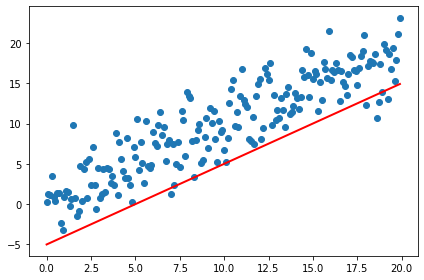

In [27]:
fig, ax = plt.subplots()
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# Plot a scatter that persists (isn't redrawn) and the initial line.
x = np.arange(0, 20, 0.1)
ax.scatter(x, x + np.random.normal(0, 3.0, len(x)))
line, = ax.plot(x, x - 5, 'r-', linewidth=2)

def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line.set_ydata(x - 5 + i)
    ax.set_xlabel(label)
    return line, ax

if __name__ == '__main__':
    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=200)
    if len(sys.argv) > 1 and sys.argv[1] == 'save':
        anim.save('line.gif', dpi=80, writer='imagemagick')
    else:
        # plt.show() will just loop the animation forever.
        plt.show()
        
plt.savefig('test.gif')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(1,6):
    fig = plt.figure()
    frames.append([fig])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')
plt.show()

In [ ]:
from IPython.display import HTML

In [ ]:
def animation_function(fig1,ax1,ax2):

    #################################################################
    
    def animate(i):
        
        if i<10:
            ax1.scatter([np.random.rand(1)],[np.random.rand(1)])
        else:
            return(ani)

    ani = FuncAnimation(fig1, animate, interval=1000)

    return(ani)

In [ ]:
%matplotlib inline

# Set up the figure
fig1 = plt.figure(figsize=(10,6))

ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

# Run the animation script
ani = animation_function(fig1,ax1,ax2)
plt.close()

# Send the animation to string
html = HTML(ani.to_jshtml()).data

with open('html_file.html', 'w') as f:
    f.write(html)

In [ ]:
for scenario in AIS_scenarios.keys():
    for rcp in AIS_scenarios[scenario].keys():
        print(AIS_scenarios[scenario][rcp]['quantiles_dict'].keys())

In [ ]:
quantiles

In [ ]:
display(Image(filename))

In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(test)
print(soup.get_text())

In [ ]:
dir(HTML)

In [ ]:
import IPython